# Lunar Lander V-3  
## REINFORCE Algorithm  

### CSCI4050 Final Project  
### Project Code 22

**Neel Shah** - 100789924  
**Dev Thaker**  -100808882

github link: https://github.com/nshah271/LunarLanderV-3_RL_Solution.git 


In [5]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import numpy as np
import os
import json

In [6]:
env = gym.make("LunarLander-v3", render_mode="human")


print("Environment Details")
print("-" * 40)

# Action Space
print(f"{'Action Space:':<20} {env.action_space}")

# Observation Space
print(f"{'Observation Space:':<20} {env.observation_space}")

# Observation Space High
print("\nObservation Space High:")
for i, value in enumerate(env.observation_space.high):
    print(f"  Dimension {i+1}: {value}")

# Observation Space Low
print("\nObservation Space Low:")
for i, value in enumerate(env.observation_space.low):
    print(f"  Dimension {i+1}: {value}")

Environment Details
----------------------------------------
Action Space:        Discrete(4)
Observation Space:   Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)

Observation Space High:
  Dimension 1: 2.5
  Dimension 2: 2.5
  Dimension 3: 10.0
  Dimension 4: 10.0
  Dimension 5: 6.2831854820251465
  Dimension 6: 10.0
  Dimension 7: 1.0
  Dimension 8: 1.0

Observation Space Low:
  Dimension 1: -2.5
  Dimension 2: -2.5
  Dimension 3: -10.0
  Dimension 4: -10.0
  Dimension 5: -6.2831854820251465
  Dimension 6: -10.0
  Dimension 7: -0.0
  Dimension 8: -0.0


In [32]:
os.makedirs("logs", exist_ok=True)

In [7]:
learning_rate = 0.01
gamma = 0.99  # Discount factor

In [8]:
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return torch.softmax(x, dim=-1)

In [10]:
policy = PolicyNetwork(input_dim=env.observation_space.shape[0], output_dim=env.action_space.n)
optimizer = optim.Adam(policy.parameters(), lr=learning_rate)

In [11]:
import os
import json
import torch
from torch.distributions import Categorical

def reinforce(policy, optimizer, episodes=1000, max_steps=500, gamma=0.99, save_path="logs"):
    """
    Train a policy using REINFORCE, log loss and rewards, and save models.

    Args:
        policy: The policy network.
        optimizer: Optimizer for training.
        episodes: Number of episodes to train.
        max_steps: Max steps per episode.
        gamma: Discount factor.
        save_path: Directory to save logs and models.
    """
    # Create the logs directory if it doesn't exist
    os.makedirs(save_path, exist_ok=True)

    logs = []  # List to store loss and rewards
    best_reward = float('-inf')  # Initialize best reward to negative infinity
    best_model_path = os.path.join(save_path, "best_model.pth")

    for episode in range(episodes):
        state, _ = env.reset()
        log_probs = []
        rewards = []
        total_reward = 0

        for t in range(max_steps):
            state_tensor = torch.tensor(state, dtype=torch.float32)
            action_probs = policy(state_tensor)
            action_dist = Categorical(action_probs)
            action = action_dist.sample()
            log_probs.append(action_dist.log_prob(action))

            next_state, reward, done, truncated, _ = env.step(action.item())
            rewards.append(reward)
            total_reward += reward

            if done or truncated:
                break
            state = next_state

        # Compute the discounted rewards
        discounted_rewards = []
        cumulative_reward = 0
        for r in reversed(rewards):
            cumulative_reward = r + gamma * cumulative_reward
            discounted_rewards.insert(0, cumulative_reward)

        discounted_rewards = torch.tensor(discounted_rewards, dtype=torch.float32)
        discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9)  # Normalize rewards

        # Compute the loss
        loss = 0
        for log_prob, reward in zip(log_probs, discounted_rewards):
            loss -= log_prob * reward  # REINFORCE loss

        # Perform gradient update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Log loss and rewards
        logs.append({
            "episode": episode + 1,
            "total_reward": total_reward,
            "loss": loss.item()
        })

        # Save the best model if a new best reward is achieved
        if total_reward > best_reward:
            best_reward = total_reward
            torch.save(policy.state_dict(), best_model_path)
            print(f"New best model saved with reward: {best_reward:.2f}")

        # Print progress
        print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward:.2f}, Loss: {loss.item():.4f}")

    # Save logs to a JSON file
    logs_path = os.path.join(save_path, "training_logs.json")
    with open(logs_path, "w") as file:
        json.dump(logs, file, indent=4)
    print(f"Training logs saved to '{logs_path}'")

    # Save the final model
    final_model_path = os.path.join(save_path, "final_model.pth")
    torch.save(policy.state_dict(), final_model_path)
    print(f"Final model saved to '{final_model_path}'")

    # Confirm best model
    print(f"Best model saved with reward: {best_reward:.2f} at '{best_model_path}'")


In [37]:
reinforce(policy, optimizer, episodes=1000)

New best model saved with reward: -272.67
Episode 1/1000, Total Reward: -272.67, Loss: -1.1388
Episode 2/1000, Total Reward: -289.65, Loss: 1.4693
New best model saved with reward: -98.69
Episode 3/1000, Total Reward: -98.69, Loss: -0.1382
New best model saved with reward: -33.08
Episode 4/1000, Total Reward: -33.08, Loss: 1.6114
Episode 5/1000, Total Reward: -456.66, Loss: 12.6099
Episode 6/1000, Total Reward: -199.60, Loss: -1.8056
Episode 7/1000, Total Reward: -436.87, Loss: 0.1250
Episode 8/1000, Total Reward: -483.71, Loss: -6.3925
Episode 9/1000, Total Reward: -449.22, Loss: 6.4352
Episode 10/1000, Total Reward: -615.85, Loss: -7.6748
Episode 11/1000, Total Reward: -344.15, Loss: 2.7175
Episode 12/1000, Total Reward: -490.57, Loss: -12.1227
Episode 13/1000, Total Reward: -402.37, Loss: -1.4772
Episode 14/1000, Total Reward: -441.56, Loss: -11.1862
Episode 15/1000, Total Reward: -612.10, Loss: -20.4530
Episode 16/1000, Total Reward: -300.97, Loss: -0.6805
Episode 17/1000, Total Re

In [13]:
policy = PolicyNetwork(input_dim=env.observation_space.shape[0], output_dim=env.action_space.n)
policy.load_state_dict(torch.load("best_model.pth"))
policy.eval()  # Set the policy to evaluation mode

# Test the model
def test_model(policy, env, episodes=5, max_steps=500):
    for episode in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        for t in range(max_steps):
            state_tensor = torch.tensor(state, dtype=torch.float32)
            with torch.no_grad():  # Disable gradient computation for testing
                action_probs = policy(state_tensor)
                action = torch.argmax(action_probs).item()  # Select the action with the highest probability
            state, reward, done, truncated, _ = env.step(action)
            total_reward += reward
            if done or truncated:
                break
        print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}")

# Run the test
test_model(policy, env, episodes=5)

Episode 1/5, Total Reward: 102.13674411677965
Episode 2/5, Total Reward: 82.77258640545595
Episode 3/5, Total Reward: 92.15081648275765
Episode 4/5, Total Reward: 73.54430488264963
Episode 5/5, Total Reward: 93.90768704203828


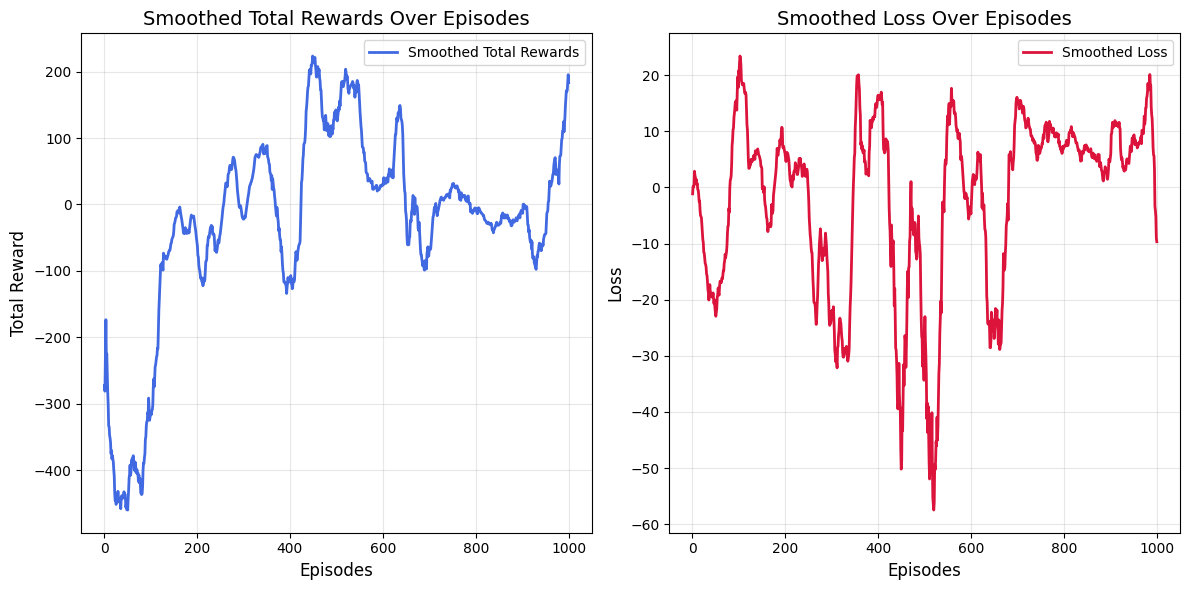

In [16]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Path to the logs file
logs_path = "training_logs.json"

# Load the training logs
with open(logs_path, "r") as file:
    logs = json.load(file)

# Extract episode numbers, rewards, and loss values
episodes = [log["episode"] for log in logs]
total_rewards = [log["total_reward"] for log in logs]
loss_values = [log["loss"] for log in logs]

# Smoothing function (rolling average)
def smooth(data, window_size=20):
    return pd.Series(data).rolling(window=window_size, min_periods=1).mean()

# Smooth the data
smoothed_rewards = smooth(total_rewards, window_size=20)
smoothed_loss = smooth(loss_values, window_size=20)

# Plot Total Rewards
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(episodes, smoothed_rewards, label="Smoothed Total Rewards", color="royalblue", linewidth=2)
plt.xlabel("Episodes", fontsize=12)
plt.ylabel("Total Reward", fontsize=12)
plt.title("Smoothed Total Rewards Over Episodes", fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(episodes, smoothed_loss, label="Smoothed Loss", color="crimson", linewidth=2)
plt.xlabel("Episodes", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Smoothed Loss Over Episodes", fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


Reward Analysis:
1. Initially, the agent performs poorly, receiving large negative rewards due to random actions and crashes.
2. Around episode 400–600, the rewards peak as the agent successfully lands the lunar module consistently.
3. The slight drop in performance toward the middle indicates some instability, but rewards stabilize again towards the end, demonstrating the agent’s progress

Loss Analysis:
1. Initially, the loss fluctuates as the agent explores and updates its policy based on random actions.
2. Around episodes 400–600, the loss shows sharp dips, likely corresponding to significant updates when the agent learns better policies.
3. Toward the end, the loss stabilizes near 0, indicating the agent is approaching convergence, as it has learned a policy that minimizes the REINFORCE loss function.